In [1]:
# To have each Python cell auto-formatted
# See: https://black.readthedocs.io
%load_ext lab_black

# Training MNIST with MXNet

## Introduction
Recognizing handwritten digits based on the [MNIST (Modified National Institute of Standards and Technology) data set](http://yann.lecun.com/exdb/mnist/) is the "Hello, World" example of machine learning.
Each (anti-aliased) black-and-white image represents a digit from 0 to 9 and has been fit into a 28x28 pixel bounding box.
The problem of recognizing digits from handwriting is, for instance, important to the postal service when automatically reading zip codes from envelopes.

### What You'll Learn
We'll show you how to use Apache MXNet to build a model with two convolutional layers and two fully connected layers to perform the multi-class classification of images provided.
An approach using the `Sequential` layer type is available [here](https://mxnet.incubator.apache.org/api/python/docs/tutorials/packages/gluon/image/mnist.html).

### What You'll Need
All you need is this notebook.

## How to Load and Inspect the Data
Before we proceed, let's check that we're using the right image, that is, [MXNet](https://mxnet.apache.org/api/python/docs/api/) is available:

In [2]:
! pip list | grep mxnet

mxnet-cu102mkl           1.6.0

Yes!

Let's import the necessary Python modules and load the data:

In [3]:
import mxnet as mx
import numpy as np

import gzip
import logging
import struct


logging.getLogger().setLevel(logging.INFO)


def get_mnist():
    """
    Utility method to load the MNIST dataset stored on disk.
    This is a modification of the original test_utils.get_mnist() function available in MXNet.
    
    Link:
    https://mxnet.apache.org/versions/1.6/api/python/docs/_modules/mxnet/test_utils.html#get_mnist
    """
    def read_data(label_url, image_url):
        with gzip.open(label_url) as flbl:
            struct.unpack(">II", flbl.read(8))
            label = np.frombuffer(flbl.read(), dtype=np.int8)
        with gzip.open(image_url, "rb") as fimg:
            _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
            image = np.frombuffer(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
            image = image.reshape(image.shape[0], 1, 28, 28).astype(np.float32)/255
        return label, image

    path = "datasets/mnist/"
    (train_lbl, train_img) = read_data(path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
    (test_lbl, test_img) = read_data(path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')
    
    return {'train_data':train_img, 'train_label':train_lbl, 'test_data':test_img, 'test_label':test_lbl}


mnist = get_mnist()

We expect to receive a `dict`, so for future reference we can look at the available keys:

In [4]:
mnist.keys()

dict_keys(['train_data', 'train_label', 'test_data', 'test_label'])

How is the data structured?
We can see that by grabbing an example and asking for the shape of the array:

In [5]:
example = mnist["train_data"][42]
example.shape

(1, 28, 28)

So, we have `(batch, height, width)` because `batch = 1` for a single example.
For RGB images, we'd have `(batch, height, width, channels)` with `channels = 3`.
What does the image itself look like?

In [6]:
import numpy as np

from matplotlib import pyplot as plt

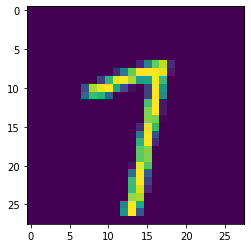

In [7]:
%matplotlib inline
plt.imshow(np.squeeze(example))
plt.show()

That could be both a 1 or a 7, so let's check what the label says:

In [8]:
mnist["train_label"][42]

7

Just to be on the safe side, we need to check our pixel values have already been scaled into the [0, 1] range:

In [9]:
flattened = example.flatten()
min(flattened), max(flattened)

(0.0, 1.0)

## How to Train the Model

We shall make use of the following convenience function to create a single convolutional layer with a certain `activation` function followed by a pre-defined max pooling layer.
Since we intend to have two such layers in our model, it makes sense to package a single layer as a re-usable function.

<div class="alert alert-block alert-info">
<b>A Note on Activation Functions</b><br>
    A common choice for <a href="https://arxiv.org/abs/1606.02228">activation functions</a> is a ReLU (Rectified Linear Unit).
    It is linear for non-negative values and zero for negative ones.
    The <a href="https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/">main benefits of ReLU</a> as opposed to sigmoidal functions (e.g. logistic or `tanh`) are:
    <ul>
        <li>ReLU and its gradient are very cheap to compute;</li>
        <li>Gradients are less likely to vanish, because for (non-)negative values its gradient is constant and therefore does not saturate, which for deep neural networks can <a href="https://dl.acm.org/doi/10.1145/3065386">accelerate convergence</a></li>
        <li>ReLU has a regularizing effect, because it promotes <a href="https://www.researchgate.net/publication/215616967_Deep_Sparse_Rectifier_Neural_Networks">sparse representations</a> (i.e. some nodes' weights are zero);</li> 
        <li>Empirically it has been found to work well.</li>
    </ul>
    ReLU activation functions can cause neurons to 'die' because a large, negative (learned) bias value causes all inputs to be negative, which in turn leads to a zero output.
    The neuron has thus become incapable of discriminating different input values.
    So-called leaky ReLU activations functions address that issue; these functions are linear but non-zero for negative values, so that their gradients are small but non-zero.
    <a href="https://arxiv.org/abs/1511.07289">ELUs</a>, or exponential linear units, are another solution to the problem of dying neurons.
</div>

In [10]:
def conv_layer(input_layer, kernel, num_filters, activation):
    """
    Defines a CNN layer with `activation` function and 2D max pooling with a kernel and stride of (2, 2)
    
    :param layer: input layer (an MXNet symbol)
    :param kernel: 2D convolutional kernel
    :param filters: number of filters to use in convolution
    :param activation: activation function (e.g. "tanh" or "relu")
    :rtype: mxnet.symbol.symbol.Symbol
    """
    conv = mx.sym.Convolution(data=input_layer, kernel=kernel, num_filter=num_filters)
    act = mx.sym.Activation(data=conv, act_type=activation)
    pool = mx.sym.Pooling(data=act, pool_type="max", kernel=(2, 2), stride=(2, 2))
    return pool

<div class="alert alert-block alert-info">
    <b>A Note on CNNs</b><br>
    While it is not our intention to cover the basics of <a href="https://www.deeplearningbook.org/contents/convnets.html">convolutional neural networks</a> (CNNs), there are a few matters worth mentioning.
    Convolutional layers are spatial feature extractors for images.
    A series of convolutional kernels (of the same dimensions) is applied to the image to obtain different versions of the same base image (i.e. filters).
    These filters extract patterns hierarchically.
    In the first layer, filters typically capture dots, edges, corners, and so on.
    With each additional layer, these patterns become more complex and turn from basic geometric shapes into constituents of objects and entire objects.
    That is why often the number of filters increases with each additional convolutional layer: to extract more complex patterns.<br><br>
    Convolutional layers are often followed by a pooling layer to down-sample the input.
    This aids in lowering the computational burden as we increase the number of filters.
    A max pooling layer simply picks the largest value of pixels in a small (rectangular) neighbourhood of a single channel (e.g. RGB). 
    This has the effect of making features <em>locally</em> translation-invariant, which is often desired: whether a feature of interest is on the left or right edge of a pooling window, which is also referred to as a kernel, is largely irrelevant to the problem of image classification.
    Note that this may not always be a desired characteristic and depends on the size of the pooling kernel.
    For instance, the precice location of tissue damage in living organisms or defects on manufactured products may be very significant indeed.
    Pooling kernels are generally chosen to be relatively small compared to the dimensions of the input, which means that local translation invariance is often desired. <br><br>
    Another common component of CNNs is a dropout layer.
    <a href="http://jmlr.org/papers/v15/srivastava14a.html">Dropout</a> provides a mechanism for regularization that has proven successful in many applications.
    It is suprisingly simple: some nodes' weights (and biases) in a specific layer are set to zero <em>at random</em>, that is, arbitrary nodes are removed from the network during the training step.
    This causes the network to not rely on any single node (a.k.a. neuron) for a feature, as each node can be dropped at random.
    The network therefore has to learn redundant representations of features.
    This is important because of what is referred to as <em>internal covariate shift</em> (often mentioned in connection with <a href="http://proceedings.mlr.press/v37/ioffe15.html">batch normalization</a>): the change of distributions of internal nodes' weights due to all other layers, which can cause nodes to stop learning (i.e. updating their weights).
    Thanks to dropout, layers become more robust to changes, although it also means it limits what can be learnt (as always with regularization).
    Still, dropout is the neural network's equivalent of the saying you should never put all your eggs in one basket.
    Layers with a high risk of overfitting (e.g. layers with many units and lots of inputs) typically have a higher dropout rate.
    <br><br>
    A nice visual explanation of convolutional layers is available <a href="https://cezannec.github.io/Convolutional_Neural_Networks/">here</a>.
    If you're curious what a CNN "sees" while training, you can have a look <a href="https://poloclub.github.io/cnn-explainer/">here</a>.
</div>

With the following function we create an ANN with two convolutional layers (as defined above), two fully connected layers with a different number of , and an output layer with a softmax function.
In each of the layers, we choose the same activation function, although that is not needed and can easily be changed.

In [11]:
def ann(input_layer, kernels, filters, activation, hidden_units):
    """
    Defines a neural network with two convolutional layers and two dense layers.
    To train the model it needs to be wrapped in a module.
    
    :param input_layer: input layer (an MXNet symbol)
    :param kernels: a list of 2D convolutional kernels
    :param filters: a list of convolutional filters
    :param activation: the activation function for all layers (e.g. "tanh" or "relu")
    :param hidden_units: a list of hidden units for the dense layers
    :rtype: mxnet.symbol.symbol.Symbol
    """
    conv1 = conv_layer(
        input_layer=input_layer,
        kernel=kernels[0],
        num_filters=filters[0],
        activation=activation,
    )
    conv2 = conv_layer(
        input_layer=conv1,
        kernel=kernels[1],
        num_filters=filters[1],
        activation=activation,
    )

    flattened = mx.sym.flatten(data=conv2)

    fc1 = mx.sym.FullyConnected(data=flattened, num_hidden=hidden_units[0])
    fc1_out = mx.sym.Activation(data=fc1, act_type=activation)

    fc2 = mx.sym.FullyConnected(data=fc1_out, num_hidden=hidden_units[1])

    out = mx.sym.SoftmaxOutput(data=fc2, name="softmax")
    return out

Now it's time to define an execution context for the model training.
If GPUs are available the model is trained on there.
If not, it defaults to using CPUs.

Since we can use the context across training instances (e.g. if we want to see the effect of a different activation function), we can define it outside the main training loop:

In [12]:
context = mx.cpu()
if mx.context.num_gpus() > 0:
    context = mx.gpu()

In [ ]:
epochs = 10
batch_size = 100

In [13]:
def train(
    data,
    context,
    epochs,
    batch_size,
    learning_rate=0.1,
    activation="tanh",
    kernels=[(5, 5), (5, 5)],
    filters=[20, 50],
    hidden_units=[500, 10],
):
    # Create an iterator for the training data with a fixed `batch_size`
    # We shuffle the data to ensure each batch is representative of the entire data set
    # Note that we can also use `mxnet.test_utils.get_mnist_iterator`
    train_iter = mx.io.NDArrayIter(
        data["train_data"], data["train_label"], batch_size, shuffle=True
    )

    # Create an iterator for the test data with a fixed `batch_size`
    # No need to shuffle the test data!
    eval_iter = mx.io.NDArrayIter(data["test_data"], data["test_label"], batch_size)

    # Define a symbolic (placeholder) variable
    images = mx.sym.Variable("data")

    # Create the artificial neural network based
    net = ann(images, kernels, filters, activation, hidden_units)

    # To be able to train (and evaluate) a model, we need the execution `context`,
    # and we must wrap the (output) symbol `net` in a module.
    model = mx.module.Module(symbol=net, context=context)

    # Train using a stochastic gradient descent algorithm with respect to the test accuracy
    model.fit(
        train_iter,
        eval_data=eval_iter,
        optimizer="sgd",
        optimizer_params={"learning_rate": learning_rate},
        eval_metric="acc",
        batch_end_callback=mx.callback.Speedometer(batch_size, 100),
        num_epoch=epochs,
    )

    # Define another iterator and use the `score` method our `model` module
    # to compute the accuracy.
    # Note: We can see the accuracy on the training and test data set from the logs,
    # but it's convenient to return it from the function, together with the model, so
    # we can call `model.predict(...)` on it.
    test_iter = mx.io.NDArrayIter(mnist["test_data"], mnist["test_label"], batch_size)
    acc = mx.metric.Accuracy()
    model.score(test_iter, acc)
    return model, acc

Let's invoke it with the defaults (and our pre-defined parameters):

In [14]:
model, acc = train(mnist, context, epochs, batch_size)

INFO:root:Epoch[0] Batch [0-100]	Speed: 1353.96 samples/sec	accuracy=0.114356
INFO:root:Epoch[0] Batch [100-200]	Speed: 1438.84 samples/sec	accuracy=0.113700
INFO:root:Epoch[0] Batch [200-300]	Speed: 1464.64 samples/sec	accuracy=0.112600
INFO:root:Epoch[0] Batch [300-400]	Speed: 1523.29 samples/sec	accuracy=0.109100
INFO:root:Epoch[0] Batch [400-500]	Speed: 1467.58 samples/sec	accuracy=0.113200
INFO:root:Epoch[0] Train-accuracy=0.112033
INFO:root:Epoch[0] Time cost=41.259
INFO:root:Epoch[0] Validation-accuracy=0.113500
INFO:root:Epoch[1] Batch [0-100]	Speed: 1490.50 samples/sec	accuracy=0.113069
INFO:root:Epoch[1] Batch [100-200]	Speed: 1425.70 samples/sec	accuracy=0.202600
INFO:root:Epoch[1] Batch [200-300]	Speed: 1297.02 samples/sec	accuracy=0.698700
INFO:root:Epoch[1] Batch [300-400]	Speed: 1369.69 samples/sec	accuracy=0.866400
INFO:root:Epoch[1] Batch [400-500]	Speed: 1276.43 samples/sec	accuracy=0.904900
INFO:root:Epoch[1] Train-accuracy=0.616617
INFO:root:Epoch[1] Time cost=44.17

<div class="alert alert-block alert-info">
    <b>A Note on Accuracy</b><br>
    We can see from the logs that the accuracy on both training and test data are relatively close.
    A training accuracy that is significantly higher than the test accuracy is an indication of a model that overfits: it picks up on noise rather than the signal that's present in the data.
    This model, therefore, does a decent job of classifying digits in images.
</div>

Because we wrapped out training process in a function, we can easily see the impact of a different activation function:

In [15]:
model_relu, acc_relu = train(mnist, context, epochs, batch_size, activation="relu")

INFO:root:Epoch[0] Batch [0-100]	Speed: 1693.27 samples/sec	accuracy=0.111089
INFO:root:Epoch[0] Batch [100-200]	Speed: 1739.83 samples/sec	accuracy=0.118500
INFO:root:Epoch[0] Batch [200-300]	Speed: 1768.59 samples/sec	accuracy=0.105400
INFO:root:Epoch[0] Batch [300-400]	Speed: 1870.50 samples/sec	accuracy=0.112700
INFO:root:Epoch[0] Batch [400-500]	Speed: 1777.87 samples/sec	accuracy=0.111900
INFO:root:Epoch[0] Train-accuracy=0.112017
INFO:root:Epoch[0] Time cost=33.978
INFO:root:Epoch[0] Validation-accuracy=0.113500
INFO:root:Epoch[1] Batch [0-100]	Speed: 1813.15 samples/sec	accuracy=0.117228
INFO:root:Epoch[1] Batch [100-200]	Speed: 1764.89 samples/sec	accuracy=0.107800
INFO:root:Epoch[1] Batch [200-300]	Speed: 1798.58 samples/sec	accuracy=0.113700
INFO:root:Epoch[1] Batch [300-400]	Speed: 1880.55 samples/sec	accuracy=0.235100
INFO:root:Epoch[1] Batch [400-500]	Speed: 1829.45 samples/sec	accuracy=0.713800
INFO:root:Epoch[1] Train-accuracy=0.360967
INFO:root:Epoch[1] Time cost=32.82

In [16]:
print(f"Accuracy: {acc} (tanh) vs {acc_relu} (ReLU)")

Accuracy: EvalMetric: {'accuracy': 0.9877} (tanh) vs EvalMetric: {'accuracy': 0.9878} (ReLU)


This is just a simple example of fiddling with hyperparameters.
If we wanted to [tune hyperparameters (with Katib)](../../katib/Hyperparameter%20Tuning.ipynb) automatically, we could simply pass these hyperparameters as arguments to container that contains a script with all necessary imports and functions to run the train-and-evaluate process.

## How to Predict with a Trained Model
Batch predictions based on a trained model are easy:

In [17]:
def test_iter(data=mnist, batch_size=100):
    return mx.io.NDArrayIter(data["test_data"], None, batch_size=batch_size)


prob = model.predict(test_iter())
prob_relu = model_relu.predict(test_iter())

If we pick a random example, we can see the probabilities per category (i.e. digit):

In [18]:
prob[24], prob_relu[24]

(
 [3.88936355e-10 5.50869439e-09 1.38218335e-08 1.33717464e-11
  9.99999046e-01 1.08974885e-09 3.25030669e-07 8.28973228e-08
  1.59384072e-07 3.14834097e-07]
 <NDArray 10 @cpu(0)>,
 
 [6.4347176e-08 7.3004806e-08 3.4015596e-08 5.8196594e-09 9.9998724e-01
  1.2476704e-07 1.9580840e-07 3.0599865e-06 1.2806310e-08 9.1640350e-06]
 <NDArray 10 @cpu(0)>)

The highest probabily is observed for the fourth index (i.e. the digit '4'):

In [19]:
np.argmax(prob[24]), np.argmax(prob_relu[24])

(
 [4.]
 <NDArray 1 @cpu(0)>,
 
 [4.]
 <NDArray 1 @cpu(0)>)

Since we did not shuffle data for the iterator `test_iter` that was used to generate probabilities we can use the same index to obtain the label to verify that the model predicts the digit correctly:

In [20]:
mnist["test_label"][24]

4